In [2]:
## Read in the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
sample_size=10000

In [4]:
X1_dist = tfp.distributions.Normal(loc=5, scale=1)
X1 = X1_dist.sample(sample_size)
X2_dist = tfp.distributions.Normal(loc=2, scale=1)
X2 = X2_dist.sample(sample_size)

In [5]:
y = 2*X1 + 3*X2 + tfp.distributions.Normal(loc=0, scale=1).sample(sample_size)

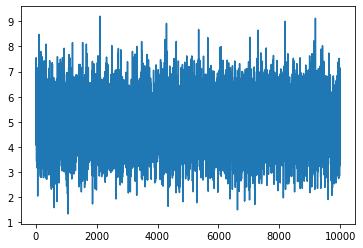

In [6]:
plt.plot(X1)
plt.show()

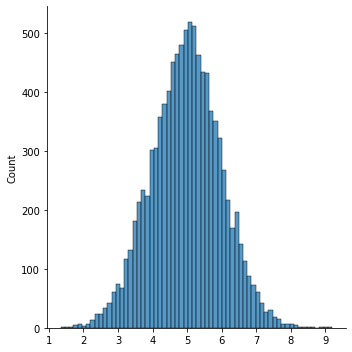

In [7]:
print(sns.displot(X1))

<AxesSubplot:>

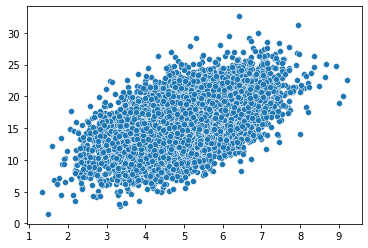

In [8]:
sns.scatterplot(x=X1, y=y)

In [13]:
fitted_model = tfp.glm.fit(model_matrix = tf.concat([X1[..., np.newaxis], X2[..., np.newaxis]], axis=-1), response=y, model = tfp.glm.Normal())

In [14]:
fitted_model[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.9943832, 3.0134685], dtype=float32)>

## Monti-carlo markov chains for approximating CI

In [19]:
def multi_sampling_coeff(X1, X2, samples = 1000):
    np_coeff = np.empty(shape=(samples, 2))

    num_obs = 500  


    for i in range(samples):
        X1_obs = X1.sample(num_obs)
        X2_obs = X2.sample(num_obs)
        y = 2*X1_obs + 3*X2_obs + tfp.distributions.Normal(loc=0, scale=1).sample(num_obs)
        fitted_model = tfp.glm.fit(model_matrix=tf.concat([X1_obs[..., np.newaxis], X2_obs[..., np.newaxis]], axis=-1), response=y, model = tfp.glm.Normal())
        np_coeff[i, :] = fitted_model[0]

    return np_coeff

In [20]:
coeff = multi_sampling_coeff(X1=X1_dist, X2=X2_dist)

In [24]:
coeff[:, 0].mean(), coeff[:, 1].mean()

(2.0006013177633286, 2.9986481111049654)

In [27]:
coeff[:, 0].std(), coeff[:, 1].std()

(0.017723773765258764, 0.04113626989051148)

# Rerunninig with statsmodel api

In [29]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

In [33]:
y.shape

TensorShape([10000])

In [41]:
sample_df = pd.DataFrame(tf.concat([X1[..., np.newaxis], X2[..., np.newaxis], y[..., np.newaxis]], axis=1), columns=['X1', 'X2', 'y'])

In [42]:
sample_df

,X1,X2,y
0,4.143011,3.405968,19.398197
1,4.294794,2.961138,17.166155
2,5.320714,3.785528,23.782951
3,5.682470,1.870462,16.864386
4,5.040485,1.453257,14.799303
...,...,...,...
9995,5.251881,3.243400,20.305525
9996,4.681383,3.237488,19.078215
9997,5.100573,0.544490,13.193659
9998,7.143602,3.194982,25.230110


In [48]:
ols_fitted_model = sm.OLS.from_formula('y ~ -1 + X1 + X2', sample_df).fit()

In [50]:
ols_fitted_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.996     
Dependent Variable:     y                AIC:                         28429.3510
Date:                   2022-07-26 15:30 BIC:                         28443.7717
No. Observations:       10000            Log-Likelihood:              -14213.   
Df Model:               2                F-statistic:                 1.333e+06 
Df Residuals:           9998             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.996            Scale:                       1.0049    
--------------------------------------------------------------------------------------
           Coef.        Std.Err.          t           P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
X1         1.9944         0.0041       484.6652       0.0000       1.9863       2.0025
X2         3.0135         0.0094       322.0656       0.0000       2.9951       3.0318
--------------------------------------------------------------------------------
Omnibus:                   2.022             Durbin-Watson:                2.025
Prob(Omnibus):             0.364             Jarque-Bera (JB):             2.052
Skew:                      0.030             Prob(JB):                     0.358
Kurtosis:                  2.963             Condition No.:                5    
================================================================================

"""

## The coeff do match but the SE don't